In [74]:
"""
Train the Unet models here.
"""

from utils.utils import *
from comparisons.dataset import UnetNiiDataset
from comparisons.models import UNet
from utils.losses import *
import torch
from torch.utils.data import DataLoader, random_split
import wandb, logging
from tqdm import tqdm
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

In [2]:
# load dataset
label_num = 7
file_path = TRAIN_IMAGE_PATH
train_dataset = UnetNiiDataset(file_path)
device = "cuda"

in_channel = 1
out_channel = label_num

In [3]:
len(train_dataset)

3185

In [4]:
for each_data in train_dataset:
    first_img, first_mask = each_data
    break


In [5]:
print("image shape:", first_img.shape, "   ", "mask_shape: ", first_mask.shape)

image shape: (1, 256, 256)     mask_shape:  (1, 256, 256)


In [6]:
import matplotlib.pyplot as plt

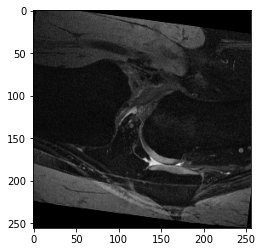

In [7]:
plt.imshow(first_img[0,:,:], cmap="gray")
plt.show()

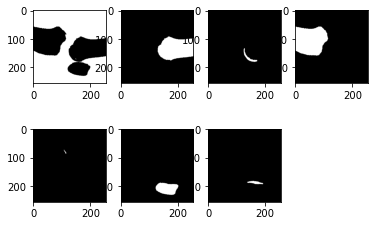

In [8]:
for i in range(7):
    plt.subplot(2,4,i+1)
    plt.imshow(first_mask[0, :, :]==i, cmap="gray")
plt.show()

In [9]:
in_channel = 1
out_channel = label_num

# load models
unet_model = UNet(in_channel, out_channel)

In [10]:
pred_msk = unet_model(torch.Tensor([first_img, first_img]).float())

/scratch/temp/8678693/ipykernel_2613020/1659485923.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847130/work/torch/csrc/utils/tensor_new.cpp:275.)
  pred_msk = unet_model(torch.Tensor([first_img, first_img]).float())


In [11]:
pred_msk.shape

torch.Size([2, 7, 256, 256])

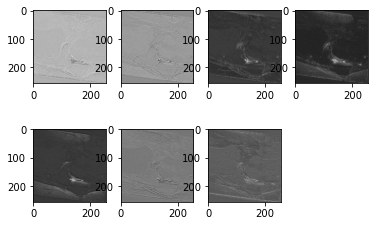

In [12]:
for i in range(7):
    plt.subplot(2,4,i+1)
    plt.imshow(pred_msk[0, i, :, :].detach().numpy(), cmap="gray")
plt.show()

In [13]:
val_percent = 0.1
n_val = int(len(train_dataset) * val_percent)
n_train = len(train_dataset) - n_val
train_set, val_set = random_split(train_dataset, [n_train, n_val], 
                                generator=torch.Generator().manual_seed(0))

In [14]:
print("whole:", len(train_dataset), "  train: ", len(train_set), "  val: ", len(val_set))

whole: 3185   train:  2867   val:  318


In [15]:
# Create data loaders
batch_size = 10
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, batch_size=batch_size)

In [16]:
print("train batch size: ", len(train_loader), "  val batch size: ", len(val_loader))

train batch size:  287   val batch size:  31


In [17]:
for batch in train_loader:
    first_batch = batch
    break

In [18]:
first_batch[0].shape

torch.Size([10, 1, 256, 256])

In [19]:
for batch in train_loader:
    images, true_masks = batch[0], batch[1]
    break

In [20]:
images = images.to(device=device, dtype=torch.float)
true_masks = true_masks.to(device=device, dtype=torch.long)

In [21]:
unet_model.to(device)
masks_pred = unet_model(images)

In [22]:
masks_pred.dtype

torch.float32

In [23]:
true_masks.unique()

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')

In [24]:
print("true_masks_min: ", true_masks.min(),"\n",
      "true_masks_max: ", true_masks.max(),"\n",
      "masks_pred_min: ", masks_pred.min(),"\n",
      "masks_pred_max: ", masks_pred.max(),"\n")

true_masks_min:  tensor(0, device='cuda:0') 
 true_masks_max:  tensor(6, device='cuda:0') 
 masks_pred_min:  tensor(-5.2926, device='cuda:0', grad_fn=<MinBackward1>) 
 masks_pred_max:  tensor(9.1073, device='cuda:0', grad_fn=<MaxBackward1>) 



# Test part

In [26]:
test_path = TEST__IMAGE_PATH
model_cp_path = "/home/s4670484/Documents/cp_temp/model_20240330_023318_2250"

In [27]:
test_dataset = UnetNiiDataset(test_path)
batch_size = 64
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [28]:
len(test_dataset)

1531

In [29]:
saved_model = UNet(n_channels=in_channel, n_classes=label_num)
saved_model.load_state_dict(torch.load(model_cp_path))
saved_model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [30]:
criterion = CeDiceLoss(num_classes=label_num)

In [45]:
first_img = first_img.detach().to(device)

In [59]:
first_img

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0',
       dtype=torch.float64)

In [56]:
output = saved_model(first_img.float().unsqueeze(0)).softmax(dim=1)

In [69]:
output1 = output.argmax(dim=1).detach().cpu().numpy()

In [67]:
output1.unique()

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')

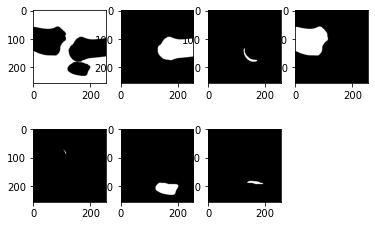

In [58]:
for i in range(7):
    plt.subplot(2,4,i+1)
    plt.imshow(output[0, i, :, :].detach().cpu().numpy(), cmap="gray")
plt.show()

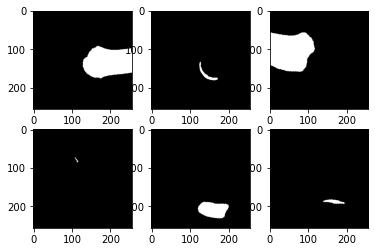

In [84]:
for i in range(1,7):
    plt.subplot(2,3,i)
    plt.imshow(first_mask[0, :, :]==i, cmap="gray")
plt.show()

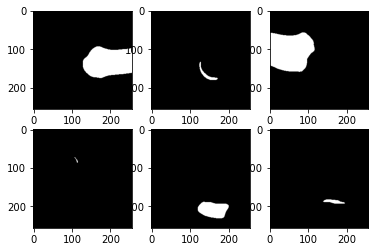

In [82]:
for i in range(1,7):
    plt.subplot(2,3,i)
    plt.imshow(output1[0, :, :]==i, cmap="gray")
plt.show()

In [31]:
saved_model.eval()
running_vloss = 0.0
with torch.no_grad():
    for i, vbatch in enumerate(test_loader):
        vinputs, vlabels = vbatch[0], vbatch[1]
        vinputs = vinputs.to(device=device, dtype=torch.float)
        vlabels = vlabels.to(device=device, dtype=torch.long)
        voutputs = saved_model(vinputs)

        vloss = criterion(
                    F.softmax(voutputs, dim=1).float(),
                    F.one_hot(vlabels.squeeze_(1), saved_model.n_classes
                            ).permute(0, 3, 1, 2).float(),
                )

        running_vloss += vloss.item()
        avg_vloss = running_vloss / (i + 1)

In [33]:
print(avg_vloss)

1.985639363527298


In [87]:
# setup essential parameters.
record = {}

for image, mask in tqdm(test_dataset):
    image = torch.tensor(image, dtype=torch.float, device=torch.device(device))
    pred_mask = saved_model(image.unsqueeze(0))
    pred_mask = pred_mask.softmax(dim=1).argmax(dim=1).detach().cpu().numpy()
        
    name = test_dataset.get_name()
    
    sub_record = []
    for label in range(1,label_num): # 1-6
        pred_mask_ = pred_mask[0,:,:]==label
        gt_mask_ = mask[0,:,:]==label
        
        dice = dice_similarity(pred_mask_, gt_mask_)
        sub_record.append(dice)

    record[name] = sub_record


100%|██████████████████████████████████████| 1531/1531 [00:13<00:00, 111.38it/s]


In [89]:
label_record = {}
for label in range(1,label_num): # 1-6
    label_record["label"+str(label)] =[]
    for name in record.keys():
        label_record["label"+str(label)].append(record[name][label-1])

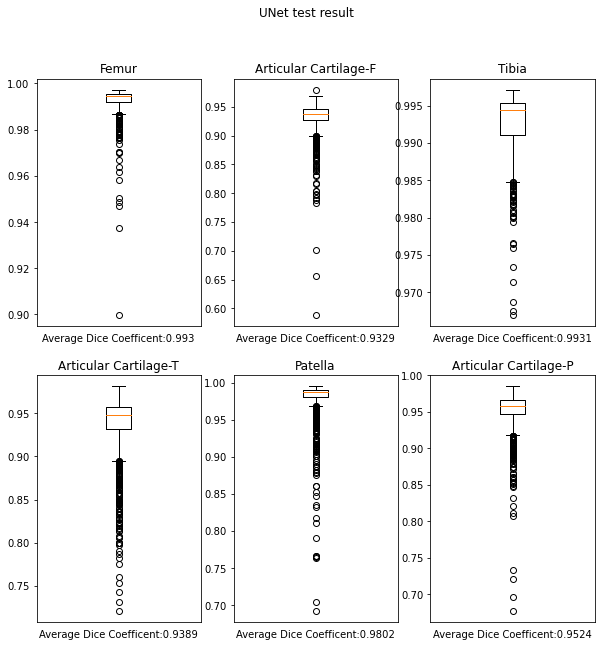

In [138]:
plt.figure(figsize=(10,10))
for i in range(1,7):
    plt.subplot(2,3,i)
    plt.boxplot(label_record["label"+str(i)])
    plt.suptitle("UNet test result")
    plt.title(LABEL_DICTIONARY[i])
    plt.xlabel("Average Dice Coefficent:"+str(round(np.mean(label_record["label"+str(i)]),4)), y=-0.1)
    plt.xticks([])
plt.show()

In [95]:
for i in range(1,7):
    print(np.mean(label_record["label"+str(i)]))

0.9929619276447132
0.9328768615756695
0.9930996461661415
0.938906966989391
0.9802477282997425
0.9524033063789835
